In [2]:
import math
# import random

import gym
import numpy

import jax
# import time
# from numpy import random

from jax import grad
import jax.numpy as np
from jax import random
from jax.ops import index, index_add, index_update


In [4]:
# from treeswift import 

In [7]:
from collections import namedtuple

nodeData = namedtuple(
    "NodeData", ["action_inbound", "state", "noise_state", "value_est", "step_reward"]
)

t = nodeData(1,2,3,4,5)
t

NodeData(action_inbound=1, state=2, noise_state=3, value_est=4, step_reward=5)

In [9]:
t.state =5

AttributeError: can't set attribute

In [24]:
F = lambda A,x: x @ A @ x

A = np.eye(2.)
x = np.array([1.,1.])

F(A,x)
dfdx = grad(F,argnums=1)

dfdx(numpy.random.randn(2,2),arr([0.,.1]))


DeviceArray([ 0.03606885, -0.05567502], dtype=float32)

In [52]:
n = 2 # state dim
m = 2 # action dim
B = numpy.random.randn(2,2)
W1 = numpy.random.randn(2,2)
W2 = numpy.random.randn(2,2)
b = numpy.random.randn(2,1)

F = lambda s, a: W2 @ np.tanh(W1 @ s + B @ a + b)

inv = numpy.linalg.pinv

invF = lambda s0,s1: inv(B) @ (np.arctanh(inv(W2) @ s1) - W1@s0 - b)
 

In [53]:
s0 = arr([[.2, 1.2]]).T
a =  arr([[.2, .2]]).T
s1 = F(s0, a)
s1
invF(s0, s1)




DeviceArray([[0.20003569],
             [0.20001987]], dtype=float32)

In [4]:
a = numpy.array([1,2,3])
b = numpy.array([20,30])
A = numpy.hstack([a,b])
I = numpy.eye(5)
I[:,2]=A
I[1,:]=A
I

array([[ 1.,  0.,  1.,  0.,  0.],
       [ 1.,  2.,  3., 20., 30.],
       [ 0.,  0.,  3.,  0.,  0.],
       [ 0.,  0., 20.,  1.,  0.],
       [ 0.,  0., 30.,  0.,  1.]])

In [2]:
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline

In [35]:
def plotHeadingSteps(pos, target, ax = None, radius = None):
    if ax is None:
        f, ax = plt.subplots(figsize=(8, 8))
    R = radius if radius is not None else np.linalg.norm(target)+1

    ax.set_aspect("equal", "box")
    ax.set_xlim([-R, R])
    ax.set_ylim([-R, R])

    ax.plot(pos[0,:],pos[1,:])
    ax.scatter([0,target[0]], [0,target[1]], c="black")

In [37]:
np.hstack([0,np.cos(np.array([1,2,3,4]))])
np.hstack([np.zeros((2,1)),random.random_sample(2,2)])
# np.zeros((2,1))

AttributeError: module 'jax.random' has no attribute 'random_sample'

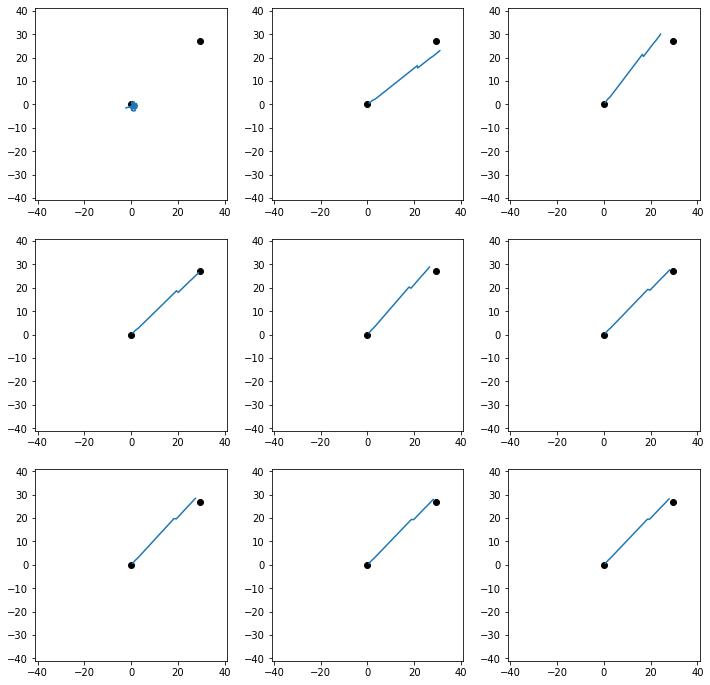

In [61]:
# trying to get to a target, taking steps of length 1 and choosing direction
key = jax.random.PRNGKey(1)

T=40
heading_inputs = random.uniform(key,(1,T))
targetDirection = random.uniform(key,(1,1))*2*np.pi
target = np.array([np.cos(targetDirection),np.sin(targetDirection)])*T

r,c = 3,3
f, axs = plt.subplots(r,c,figsize=(4*c,4*r))
axs = axs.ravel()

LR = .5

def randomStepsTrajectory(heading_inputs):
    headings = heading_inputs*2*np.pi
    steps = np.vstack([np.cos(headings),np.sin(headings)])
    pos = np.cumsum(steps,1)
    return pos

def randomStepsTrajectoryLoss(heading_inputs,target):
    finalPos = randomStepsTrajectory(heading_inputs)[:,-1]
    distance = np.sum((finalPos - target)**2)
    return distance

f = lambda H: randomStepsTrajectoryLoss(H,target)

trajectoryGrad = grad(f)

M = 5
for i in range(r*c*M):
    g = trajectoryGrad(heading_inputs)

    if i%M == 0:
        pos = randomStepsTrajectory(heading_inputs)
        plotHeadingSteps(pos, target, ax = axs[i//M])
    
    heading_inputs =  heading_inputs - LR*(0.9**i) * g/np.linalg.norm(g)


In [3]:
g = 10
m = 1
l = 1
dt = 0.05
max_torque = 2
max_speed = 8
T = 200

def angle_normalize(x):
    return ((x+np.pi) % (2*np.pi)) - np.pi

def controlledPendulumStep(th, thdot, u):
    u = np.clip(u, -max_torque, max_torque)
    cost = angle_normalize(th) ** 2 + .1 * thdot ** 2 + .001 * (u ** 2)
    newthdot = thdot + (-3 * g / (2 * l) * np.sin(th + np.pi) + 3. / (m * l ** 2) * u) * dt
    newth = th + newthdot * dt
    newthdot = np.clip(newthdot, -max_speed, max_speed)

    return np.array((newth, newthdot, cost))

def pendulumTraj(th0, thdot0, uVect):
    th, thdot = th0, thdot0
    traj = np.zeros((3,len(uVect)))
    for t,u in enumerate(uVect):
        state = controlledPendulumStep(th, thdot, u)
        traj = index_update(traj, index[:, t], state)
        th = state[0]
        thdot = state[1]
    return traj

def pendulumTrajCost(th0, thdot0, uVect):
    traj = pendulumTraj(th0, thdot0, uVect)
    cost = sum(traj[2,:])
    return cost


th0, thdot0 = 2,0

f = lambda control: pendulumTrajCost(th0, thdot0, control)

trajectoryGrad = grad(f)




In [24]:
LR=1
# iters = 10
# uVect = np.zeros(100)

# savedTrajectories = []
# savedInputs = []
for i in range(iters):
    dgdu = trajectoryGrad(uVect)

    uVect = uVect - LR*(0.9**i) * dgdu/np.linalg.norm(g)
    uVect = np.clip(uVect, -max_torque, max_torque)

    new_traj = pendulumTraj(th0, thdot0, uVect)
    print(f"iter: {i}; final cost:{pendulumTrajCost(th0, thdot0, uVect)}")
    savedTrajectories.append(new_traj)
    savedInputs.append(uVect)

iter: 0; final cost:581.8219276070595
iter: 1; final cost:581.1991946697235
iter: 2; final cost:581.3695014119148
iter: 3; final cost:580.727578163147
iter: 4; final cost:580.9299314618111
iter: 5; final cost:581.4190988540649
iter: 6; final cost:581.1154397130013
iter: 7; final cost:537.5347886011004
iter: 8; final cost:604.8442227840424
iter: 9; final cost:610.456211566925


In [119]:
len(savedInputs)

3

10 saved trajectories


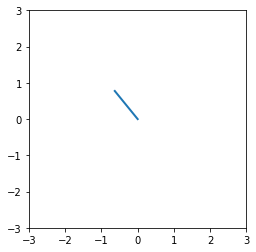

In [21]:
fig, ax = plt.subplots()

ax.set_xlim(( -3, 3))
ax.set_ylim((-3, 3))
ax.set_aspect(1)

line, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)

print(f"{len(savedTrajectories)} saved trajectories")
# saved_traj_num=4
saved_traj_num=len(savedTrajectories)-1
trajectory = savedTrajectories[saved_traj_num][0,:]
inputs = savedInputs[saved_traj_num]

def init():
    line.set_data([0,np.sin(th0)], [0,np.cos(th0)])
    line2.set_data([0,0], [-1.5,-1.5])
    return (line,line2)

def animate(i):
    tip_x = np.sin(trajectory[i])
    tip_y = np.cos(trajectory[i])

    line.set_data([0,tip_x], [0,tip_y])
    line2.set_data(
        [tip_x,tip_x + np.sin(trajectory[i]+np.pi/2)*inputs[i]],
        [tip_y,tip_y + np.cos(trajectory[i]+np.pi/2)*inputs[i]]
    )
    # line2.set_data([0, inputs[i]], [-1.5,-1.5])
    return (line,line2)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(trajectory), interval=1000*.05, 
                               blit=True)

HTML(anim.to_jshtml())

In [86]:
env.close()

In [19]:
savedInputs[-1]

DeviceArray([-1.24229240e+01,  2.42286849e+00,  2.26619196e+00,
              2.86817884e+00,  3.39731026e+00,  3.82536411e+00,
              4.12152052e+00,  4.25755692e+00,  4.21437120e+00,
              4.02205181e+00,  3.71238780e+00,  3.30658436e+00,
              2.83123255e+00,  2.31229782e+00,  2.43944955e+00,
              2.39154100e+00, -3.23162727e+01, -2.75491066e+01,
             -2.35216541e+01, -2.01847420e+01, -1.74650536e+01,
             -2.02889657e+00, -2.53974533e+00, -3.01160192e+00,
             -3.41603470e+00, -3.71805620e+00, -3.88217711e+00,
             -3.88239717e+00, -3.76430535e+00, -3.53654885e+00,
             -3.22296882e+00, -2.85460663e+00, -2.46141243e+00,
             -2.06692696e+00, -2.08372355e+00, -1.40591991e+00,
             -2.61491795e+01, -2.43499966e+01, -2.19332695e+01,
             -1.91946259e+01, -1.64002323e+01, -1.37415285e+01,
             -1.13311920e+01, -9.22079659e+00, -7.42278481e+00,
             -5.92628145e+00, -4.7098531